In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import nltk
nltk.download("all")
import matplotlib.pyplot as plt
import torch

%matplotlib inline

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\berto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\berto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     C:\Users\berto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     C:\Users\berto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     C:\Users\berto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     C:\Users\b

[nltk_data]    |   Package subjectivity is already up-to-date!
[nltk_data]    | Downloading package swadesh to
[nltk_data]    |     C:\Users\berto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package swadesh is already up-to-date!
[nltk_data]    | Downloading package switchboard to
[nltk_data]    |     C:\Users\berto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package switchboard is already up-to-date!
[nltk_data]    | Downloading package timit to
[nltk_data]    |     C:\Users\berto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package timit is already up-to-date!
[nltk_data]    | Downloading package toolbox to
[nltk_data]    |     C:\Users\berto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package toolbox is already up-to-date!
[nltk_data]    | Downloading package treebank to
[nltk_data]    |     C:\Users\berto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package treebank is already up-to-date!
[nltk_data]    | Downloading package twitter_samples to
[nltk_data]    |    

In [2]:
import pandas as pd

df = pd.read_excel('./politica.xlsx', sheet_name="Foglio1")
pd.options.display.float_format = '{:,.0f}'.format
print(f'Found {len(df)} texts.')

print(f'{df["cap_maj_master"].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df['cap_maj_master'])]

print(f'{df["testo"].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df['testo'])]

classes = [int(c) for c in df['cap_maj_master']]
documents = [d for d in df['testo']]
df = df[['cap_maj_master', 'testo']]
df.columns = ['sentiment', 'review']
df.head(3)



Found 5674 texts.
2 document(s) with no classification removed
424 document(s) with no text removed


,sentiment,review
0,1,: quali siano le determinazioni del Governo in...
1,1,: quali siano le valutazioni del Governo sugli...
2,1,- premesso che: la prospettata modifica degli ...


In [3]:
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    text=re.sub('\d+',' ',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text
import unicodedata

def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return text
def tokenizer_porter(text):
    stop=stopwords.words('italian')
    stemmer = SnowballStemmer("italian", ignore_stopwords=True)
    return [stemmer.stem(word) for word in text.split()]

In [4]:
df['review'] = df['review'].apply(preprocessor).apply(strip_accents).apply(tokenizer_porter)
df['sentiment']=df['sentiment'].astype(int)
df.head(3)

,sentiment,review
0,1,"[qual, siano, le, determin, del, govern, in, m..."
1,1,"[qual, siano, le, valut, del, govern, sugli, e..."
2,1,"[premess, che, la, prospett, modif, degli, sca..."


In [5]:
X, y = df.iloc[:,1].values, df.iloc[:,0].values
print(X.shape)
print(y.shape)

(5248,)
(5248,)


In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [7]:
from nltk.tokenize import word_tokenize
from collections import defaultdict

def tokenize(texts):
    """Tokenize texts, build vocabulary and find maximum sentence length.
    
    Args:
        texts (List[str]): List of text data
    
    Returns:
        tokenized_texts (List[List[str]]): List of list of tokens
        word2idx (Dict): Vocabulary built from the corpus
        max_len (int): Maximum sentence length
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Building our vocab from the corpus starting from index 2
    idx = 2
    for sent in texts:
        

        # Add `tokenized_sent` to `tokenized_texts`
        tokenized_texts.append(sent)

        # Add new token to `word2idx`
        for token in sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(sent))

    return tokenized_texts, word2idx, max_len

def encode(tokenized_texts, word2idx, max_len):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns:
        input_ids (np.array): Array of token indexes in the vocabulary with
            shape (N, max_len). It will the input of our CNN model.
    """

    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

In [8]:
from tqdm import tqdm_notebook

def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [9]:

tokenized_texts, word2idx, max_len = tokenize(X)
input_ids = encode(tokenized_texts, word2idx, max_len)


In [10]:
# Load pretrained vectors
print("Tokenizing...\n")
embeddings = load_pretrained_vectors(word2idx, "cc.it.300.vec")
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


<ipython-input-8-b47afdb8d107>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin):



There are 9384 / 25951 pretrained vectors found.


In [11]:
print(embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0320,  0.1485, -0.0827,  ...,  0.2329, -0.0979,  0.1566],
        [ 0.0652,  0.0253,  0.0615,  ..., -0.0311, -0.0450, -0.0271],
        ...,
        [-0.2294, -0.0269, -0.0631,  ...,  0.1661, -0.2073,  0.0126],
        [ 0.1137,  0.0190, -0.0317,  ...,  0.0396, -0.0247,  0.0026],
        [ 0.2227, -0.0111, -0.2257,  ..., -0.0008, -0.1436,  0.1566]],
       dtype=torch.float64)


In [12]:
print(input_ids)

[[  2   3   4 ...   0   0   0]
 [  2   3   4 ...   0   0   0]
 [ 59  60  61 ...   0   0   0]
 ...
 [ 59  60  71 ...   0   0   0]
 [ 59  60   8 ...   0   0   0]
 [ 59  60 790 ...   0   0   0]]


In [13]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)

def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Specify batch_size
    batch_size = 50

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
    
    return train_dataloader, val_dataloader

In [14]:
# Sample configuration:
filter_sizes = [2, 3, 4]
num_filters = [2, 2, 2]

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        
        x_embed = self.embedding(input_ids.long()).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [16]:
import torch.optim as optim

def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=num_classes,
                        dropout=0.5)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    
    criterion=criterion.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer, criterion 

In [17]:
import random
import time



def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer,criterion, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)
    countdown=epochs
    for countdown>0:
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            
            b_input_ids, b_labels = tuple(t.to(device).long() for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = criterion(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader,criterion)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                torch.save(model.state_dict(), 'tut5-model.pt')
                countdown=epochs
            else:
                countdown=countdown-1

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")
    return best_accuracy

def evaluate(model, val_dataloader,criterion):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device).long() for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = criterion(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [20]:
def predict(text, model, max_len=62):
    """Predict probability that a review is positive."""
    labels=[]
    # Tokenize, pad and encode text
    for sent in text:
        model.eval()
        tokenized=tokenizer_porter(strip_accents(preprocessor(sent)))
        if len(tokenized) < min_len:
            tokenized += ['<pad>'] * (min_len - len(tokenized))
        indexed = [word2idx.get(token, word2idx['<unk>']) for token in tokenized]
         
        tensor = torch.LongTensor(indexed).to(device)
        tensor = tensor.unsqueeze(1)
        preds = model(tensor)
        max_preds = preds.argmax(dim = 1)
        label.append(max_preds.item())
    return labels
def predictTen(text, model, max_len=62):
    """Predict probability that a review is positive."""
    labels=[]
    # Tokenize, pad and encode text
    for input_id in text:
        
        input_id = torch.tensor(input_id).to(device).unsqueeze(dim=0)
        # Compute logits
        logits = model.forward(input_id)
        preds = logits.argmax(dim=1)
        #  Compute probability
        labels.append(preds.item())
        #  Compute probability
        

    return labels

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   2.904353   |  2.840939  |   13.62   |  246.63  


Training complete! Best accuracy: 13.62%.
--------------- Fold:  1 ---------------------

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       210
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00       202
           4       0.00      0.00      0.00       102
           5       0.00      0.00      0.00       162
           6       0.00      0.00      0.00       137
           7       0.00      0.00      0.00       119
           8       0.00      0.00      0.00        54
           9       0.00      0.00      0.00       102
          10       0.00      0.00      0.00       252
          12       0.14      1.00      0.24       361
          13       0.00      0.00      0.00        54
     

c:\users\berto\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


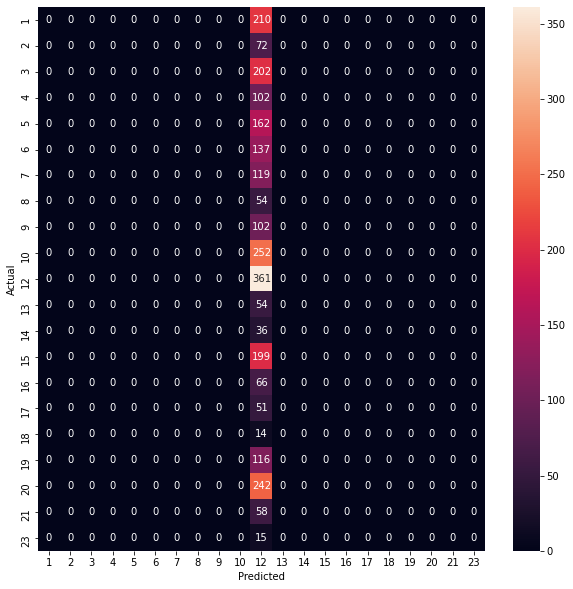


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


KeyboardInterrupt: 

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
X=input_ids
y=y
numclass=len(np.unique(y))+3
nfold=2
kfold = StratifiedKFold(n_splits=nfold).split(input_ids, y)

accuracys = []
scores= []

target_names=list(np.unique(y))

for k, (tr, test) in enumerate(kfold):
    train_dataloader, val_dataloader =data_loader(X[tr], X[test], y[tr], y[test], batch_size=50)
    # CNN-non-static: fastText pretrained word vectors are fine-tuned during training.
    
    
    set_seed(42)
    cnn_non_static, optimizer, criterion = initilize_model(pretrained_embedding=embeddings,
                                            num_classes=numclass,
                                            freeze_embedding=False,
                                            learning_rate=0.25,                                            
                                            dropout=0.5)
    accuracy=train(cnn_non_static, optimizer, criterion, train_dataloader, val_dataloader, epochs=5)
    accuracys.append(accuracy)
    cnn_non_static.load_state_dict(torch.load('tut5-model.pt'))
    y_pred=predictTen(X[test],cnn_non_static,max_len=max_len)
    
    score=precision_recall_fscore_support(y_true=y[test], y_pred=y_pred, labels=np.unique(y_pred), average="weighted")
    scores.append(score[0:3])
    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    target_names = list(map(str,target_names))
    print(metrics.classification_report(y[test], y_pred, target_names=target_names))
    conf_mat = confusion_matrix(y[test], y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=target_names , yticklabels=target_names )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print()

arr = np.array(scores)

print("Overall results of the cross-validation procedure")
print()

print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(accuracys), np.std(accuracys)))
print('\nCV precision: %.3f +/- %.3f' % (np.mean(arr[:,0]), np.std(arr[:,0])))
print('\nCV recall: %.3f +/- %.3f' % (np.mean(arr[:,1]), np.std(arr[:,1])))
print('\nCV f1: %.3f +/- %.3f' % (np.mean(arr[:,2]), np.std(arr[:,2])))
    

